# 福大通知分析

看文档看竭力了，感觉pandas文档是真的抽象，尤其是神秘索引器，一会横一会儿竖的，~所有决定先直接上手了~，还是老实看完了

In [108]:
import pandas as pd
import matplotlib.pyplot as plt

# 设置字体，防止神秘中文乱码
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

使用`read_csv`读取通知数据表，返回`DataFrame`类型

In [109]:
df: pd.DataFrame = pd.read_csv("notices.csv")
df.head(3)

,title,author,date,url,body,attaches
0,教务处通知,综合科,2003-10-22,https://jwch.fzu.edu.cn/info/1035/7900.htm,通 知10月26日因同等学历研究生入学考试安排在东教学楼和子兴教学楼，东楼和子兴楼从1...,[]
1,关于2003年12月全省高校计算机等级考试报名的通知,综合科,2003-10-22,https://jwch.fzu.edu.cn/info/1035/10799.htm,根据省教育厅通知，今年全省高校学生计算机应用水平等级考试于2003年12月20日（星期六）举...,[]
2,有关同意2003级部分学生计算机文化基础课免修的决定,综合科,2003-10-22,https://jwch.fzu.edu.cn/info/1035/7902.htm,有关同意2003级部分学生计算机文化基础课免修的决定根据“关于举办计算机文化基础课免修考试的...,[]


## 第一个问题
```
「通知人」都有谁？ 统计所有出现过的「通知人」，并计算他们各自发布的通知数量占总数的比例。
```


In [110]:
author_stat: pd.Series = df.author.value_counts(normalize=True) * 100
author_stat = author_stat.apply(lambda x: f'{x:.2f}%')

pd.DataFrame(author_stat)

,proportion
author,
教学运行,40.37%
实践科,22.76%
教研教改,10.95%
综合科,9.88%
质量办,8.66%
计划科,5.10%
教学通知,1.51%
教材中心,0.78%


## 第二个问题
```
附件下载次数与通知人的关系？ 分析附件的下载次数与通知人是否存在某种联系。比如，是不是某些特定部门发布的通知，附件下载量总是特别高？
```

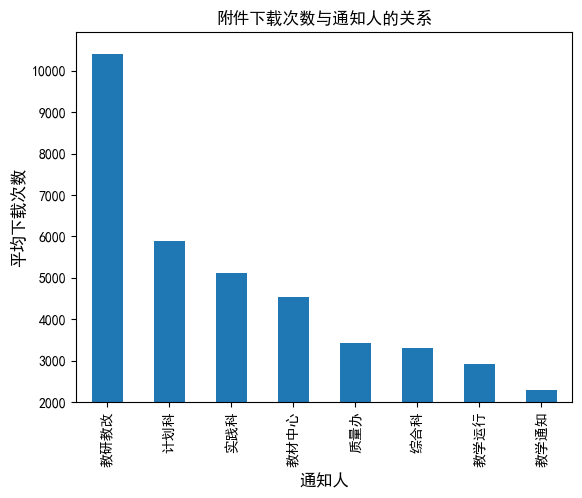

In [111]:
from typing import Any
import json

def get_attach_downloads(json_str: str) -> int:
        attaches: list[dict[str, Any]] = json.loads(json_str)
        downloads = 0
        for attach in attaches:
            downloads += attach['download_times']
        return downloads

attach_df: pd.DataFrame = df[["attaches", "author"]]
attach_df = attach_df[attach_df["attaches"] != "[]"]

attach_df["attaches_downloads"] = attach_df.attaches.apply(get_attach_downloads)
attach_stat: pd.Series = attach_df.groupby("author")["attaches_downloads"].mean().apply(int)
attach_stat = attach_stat.sort_values(ascending=False)

plt.figure()
attach_stat.plot(kind='bar')
plt.title("附件下载次数与通知人的关系", fontsize=12)
plt.xlabel("通知人", fontsize=12)
plt.ylabel("平均下载次数", fontsize=12)
plt.ylim(2000)
plt.show()


## 第三个问题
```
通知发布的高峰期？ 统计每天发布的通知数量，分析一下，通常在学期的哪个时间段，通知会变得特别密集？
```

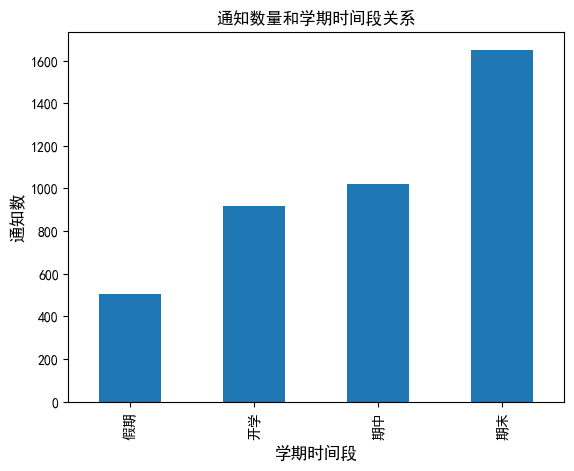

In [112]:
from datetime import date

def get_term(month: int) -> str:
    match month:
        case 12 | 1 | 5 | 6:
            return "期末"
        case 3 | 9:
            return "开学"
        case 4 | 10 | 11:
            return "期中"
        case 2 | 7 | 8:
            return "假期"

    return "假期"


df['month'] = df.date.apply(lambda x:date.fromisoformat(x).month)
df['term'] = df.month.apply(get_term)

data_stat: pd.Series = df.groupby("term").size()

plt.figure()
data_stat.plot(kind='bar')
plt.title("通知数量和学期时间段关系", fontsize=12)
plt.xlabel("学期时间段", fontsize=12)
plt.ylabel("通知数", fontsize=12)
plt.show()

## 第三个问题
```
哪些通知人的标题更长?
```

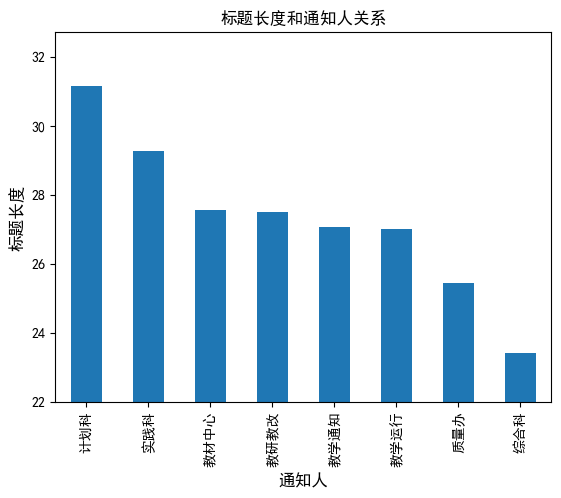

In [113]:
from statistics import mean

title_stat: pd.Series = df.groupby("author").title.agg(lambda titles: mean(len(x) for x in titles))
title_stat = title_stat.sort_values(ascending=False)

plt.figure()
title_stat.plot(kind='bar')
plt.title("标题长度和通知人关系", fontsize=12)
plt.xlabel("通知人", fontsize=12)
plt.ylabel("标题长度", fontsize=12)
plt.ylim(22)
plt.show()